# 1.3.3: World Population

<br>

---

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---


In the previous notebook we developed a population model where net growth during each time step is proportional to the current population. This model seems more realistic as an explanation of population growth than the constant growth model, but it does not fit the data as well.

<br>

We'll try one more model here, where net growth depends on the current population (as with the proportional model), but now the relationship between population and growth will be quadratic.  Let's see what that means....


<br>

---

In addition to importing the usual libraries, we'll go ahead and download the population data, using the same process as in previous chapters.  This code is hidden, just to reduce clutter, but be sure to run the cell:

In [16]:
#@title
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/World_population_estimates.html'
# If you are using this notebook offline, you will need to upload this data
# from the Images_and_Data folder on your local computer.  
# Comment out the line above, and uncomment the
# line below this one, and run this cell
# filename = '../Images_and_Data/Data/World_population_estimates.html'

tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']
un = table2.un / 1e9
census = table2.census / 1e9

def plot_estimates():
    census.plot(style=':', label='US Census',legend=True)
    un.plot(style='--', label='UN DESA', xlabel='Year', 
             ylabel='World population (billion)',
           legend=True)

---

## Quadratic Growth Model

The proportional model that we explored in the previous notebook calculates population growth as a function of the growth coefficient $\alpha$ and the current population $p$: 

$$\Delta p = \alpha p$$

where $\Delta p$ is the net annual growth in the population.

<br>


In hopes of more closely matching the population data, in this notebook we'll test out a more complex *quadratic model* that adds another term to the right hand side:

$$\Delta p = \alpha p + \beta p^2$$

where $\beta$ is a second growth coefficient.




### Implementing the model

Remember that we rewrote `run_simulation` so that it takes the change function as one of its parameters?

In [17]:
def run_simulation(system, change_func):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        growth = change_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

That comes in handy here!  All we need to do to test out our new model is to write a new change function:

In [19]:
def change_func_quad(t, pop, system):
    growth = system['alpha'] * pop + system['beta'] * pop**2
    return growth

Here's the `System` object we'll use, initialized with `t_0`, `p_0`, `t_end`, and the coefficients `alpha` and `beta`:

In [22]:
t_0 = census.index[0]
p_0 = census[t_0]
t_end = census.index[-1]
alpha = 25 / 1000
beta = -1.8 / 1000

system = dict(t_0=t_0, p_0=p_0, t_end=t_end,
              alpha=alpha, beta=beta)

`alpha` and `beta` were chosen by trial and error; we'll see better ways to do it later.    

<br> Let's call `run_simulation` and plot our results with the census data:

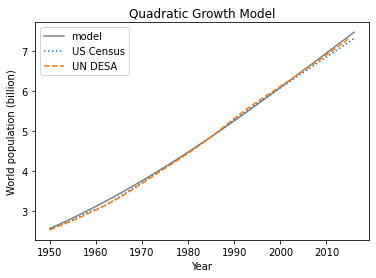

In [23]:
results = run_simulation(system, change_func_quad)
results.plot(color='gray', label='model',title='Quadratic Growth Model',
             legend=True)
plot_estimates()


The model fits the data well over the whole range, with just a bit of space between them in the 1960s.

<br>

It is not entirely surprising that the quadratic model fits better than the
constant and proportional models, because it has two parameters we can
choose where the other models have only one. In general, the more
parameters you have to play with, the better you should expect the model
to fit.

<br>

Be careful, though.  While choosing a really complex function for a curve fit might give you an accurate fit, its explanatory usefulness can suffer: what do all of those coefficients represent in the physical system?  In the proportional model we know that `alpha` meant the difference between the birth and the death rates.   But what do `alpha` and `beta` *mean* here?

<br>

In this case, the quadratic model
might be a good choice for physical reasons, too: that is, there is a
legitimate reason to expect the relationship between growth and
population to have this form.  To understand why, let's look at net growth as a function of population.

<br>

✅  Active Reading: Why might a model with a lot of coefficients be undesirable, even if it was very accurate? (Answer in a text box)

### Investigating net growth in a quadratic system

Let's plot the relationship between growth and population in the quadratic model.  To do this, we'll make an array of 101 populations from 0 to 15 billion.  In the past, when we wanted an object that contained a list of numbers, we used `range`.  But `range` only works with integers.  To get a sequence of non-integer values, we can use `linspace`, which is defined in the NumPy library:

In [24]:
import numpy as np

pop_array = np.linspace(0, 15, 101)

The arguments indicate where the sequence should start and stop, and how many elements it should contain. In this example, the sequence contains 101 equally-spaced numbers, starting at 0 and ending at 15.  The result is a NumPy array, which is a new kind of object we have not seen before. An array is a object that contains a sequence of numbers:


In [25]:
pop_array

array([ 0.  ,  0.15,  0.3 ,  0.45,  0.6 ,  0.75,  0.9 ,  1.05,  1.2 ,
        1.35,  1.5 ,  1.65,  1.8 ,  1.95,  2.1 ,  2.25,  2.4 ,  2.55,
        2.7 ,  2.85,  3.  ,  3.15,  3.3 ,  3.45,  3.6 ,  3.75,  3.9 ,
        4.05,  4.2 ,  4.35,  4.5 ,  4.65,  4.8 ,  4.95,  5.1 ,  5.25,
        5.4 ,  5.55,  5.7 ,  5.85,  6.  ,  6.15,  6.3 ,  6.45,  6.6 ,
        6.75,  6.9 ,  7.05,  7.2 ,  7.35,  7.5 ,  7.65,  7.8 ,  7.95,
        8.1 ,  8.25,  8.4 ,  8.55,  8.7 ,  8.85,  9.  ,  9.15,  9.3 ,
        9.45,  9.6 ,  9.75,  9.9 , 10.05, 10.2 , 10.35, 10.5 , 10.65,
       10.8 , 10.95, 11.1 , 11.25, 11.4 , 11.55, 11.7 , 11.85, 12.  ,
       12.15, 12.3 , 12.45, 12.6 , 12.75, 12.9 , 13.05, 13.2 , 13.35,
       13.5 , 13.65, 13.8 , 13.95, 14.1 , 14.25, 14.4 , 14.55, 14.7 ,
       14.85, 15.  ])

Now we'll use the quadratic model to compute net growth for each population, and create a `Series` that holds the relationship between population and net growth for the quadratic model.  

<br>

We can add and multiply arrays by integers in the same way we multiplied `Series` (note: to add arrays, they must have the same number of elements):

In [26]:
# Calculate the annual growth for all populations between 0 and 15 billion
growth_array = (system['alpha'] * pop_array + 
                system['beta'] * pop_array**2)

# Put this is a Series with populations as the index and the growth 
# for that population as the values
quad_net_growth = pd.Series(data=growth_array,index=pop_array)

And let's plot the relationship:

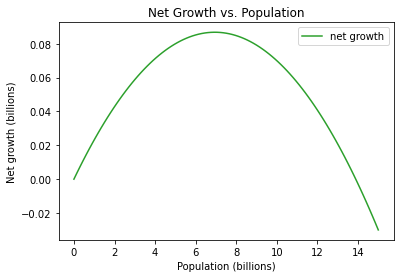

In [27]:
quad_net_growth.plot(label='net growth', color='C2',
                     xlabel='Population (billions)',
                     ylabel='Net growth (billions)',
                     title='Net Growth vs. Population',
                    legend=True);

✅ ✅ Active Reading: In the cell below, explain what is shown at each section of the plot, and why that might make sense.


✅ ✅ What is growth like when the population is 0-3 billion?

✅ ✅ 3-10 billion?

✅ ✅ 10-14 billion?

✅ ✅ Above 14 billion?  

✅ ✅ Thinking about the physical system (world population), why do you think the behavior above 14 billion might make sense?




### Finding Equilibrium

Looking at the plot above tells us several interesting things.  First, with these parameters, the peak growth rate happens when the population is between 7-8 billion.  Second, we can see a point where growth is 0.  The *equilibrium point* is the population, $p$, where net population growth, $\Delta p$, is 0.

<br>

We can compute it by finding the roots, or zeros, of this equation: 

$$\Delta p = \alpha p + \beta p^2$$ 

where $\alpha$ and $\beta$ are the parameters of the model. 
If rewrite the right hand side like this: 

$$\Delta p = p (\alpha + \beta p)$$ 

we can see that net growth $\Delta p$ is zero when either of the factors on the right hand side are zero:

 $$p=0$$
 
 $$\alpha + \beta p = 0$$

If either of these conditions is true, the population growth is zero.  The first equation tells us that this is true when the population is zero: this solution is called a "trivial" solution, because it is an obvious and not useful solution (of course there is no growth if there are no people).  The second equation, though, leads to a useful solution:

$$ p = -\alpha / \beta$$

This gives us an analytical solution to equilibrium population in our model:

In [13]:
-system['alpha']/ system['beta']

13.88888888888889

With these parameters, net growth is 0 when the population is about 13.9 billion.



In the context of population modeling, the quadratic model is more
conventionally written like this: 

$$\Delta p = r p (1 - p / K)$$ 

This is the same model; it's just a different way to *parameterize* it. By comparing this equation $\Delta p = \alpha p + \beta p^2$ and doing a little algebra, we can decipher that $r=\alpha$ and $K=-\alpha/\beta$.

<br>

Why use this more complex form of the equation?  More explanatory reasons! That is, it is easier to interpret the parameters: 

* $r$ is the unconstrained growth rate, observed when $p$ is small
* $K$ is the equilibrium point

$K$ is also called the *carrying capacity*, since it indicates the maximum population the environment can sustain.

✅ ✅  Active reading:  Look at the last equation above.  What happens to $\Delta p$ when $K = p$?  What is the right hand side of the equation equal to when $p=0$?  Explain why the two answers to these questions make sense *in terms of* the physical system (that is, world population).


✅ ✅  Answer here.

## Examining Future Growth

### Generating a projection

Let's run the quadratic model, extending the results until 2100, and see how our projections compare to the professionals'.We'll change `t_end` to 2100, and rerun our simulation using the quadratic change function and the same `alpha` and `beta` values:

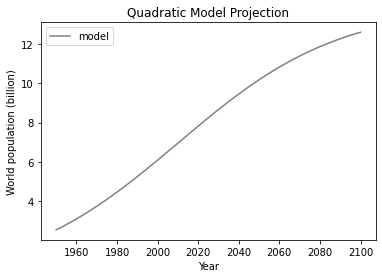

In [33]:
system['t_end'] = 2100
results = run_simulation(system, change_func_quad)
results.plot(color='gray', label='model',xlabel='Year', 
         ylabel='World population (billion)',
         title='Quadratic Model Projection',
            legend=True);

According to the model, population growth will slow gradually after 2020, approaching 12.6 billion by 2100.  Notice that even in this amount of time, the population never gets close to our projected carrying capacity of 13.8 billion.

### Projections vs. Predictions

We are using the word "projection" deliberately, rather than
"prediction":  

- "Prediction" implies "this is what we should reasonably expect to happen, at
least approximately"
- "projection" implies "if this
model is a good description of what is happening in this
system, and if nothing in the future causes the system parameters to change, this is what would happen."

So you can see that "projection" is a more careful word, with a stronger sense of a model's limitations.

Using "projection" leaves open the possibility that there are important things in the real world that are not captured in the model. It also suggests that, even if the model is good, the parameters we estimate based on the past might be different in the future.

<br>

The quadratic model we've been working with is based on the assumption
that population growth is limited by the availability of resources; in
that scenario, as the population approaches carrying capacity, birth
rates fall and death rates rise because resources become scarce.  If that assumption is valid, we might be able to use actual population
growth to estimate carrying capacity, provided we observe the
transition into the population range where the growth rate starts to fall.

But in the case of world population growth, those conditions don't
apply. Over the last 50 years, the net growth rate has leveled off, but not yet started to fall, so we don't have enough data to make a credible estimate of carrying capacity. And resource limitations are probably *not* the primary reason growth has slowed. As evidence, consider:

-   First, the death rate is not increasing; rather, it has declined
    from 1.9% in 1950 to 0.8% now.
    So the decrease in net growth is due entirely to declining birth
    rates.

-   Second, the relationship between resources and birth rate is the
    opposite of what the model assumes.  As nations develop and people
    become more wealthy, birth rates tend to fall: in other words, as resources have become *more available* to a community, the birth rate has tended to fall.

For these reasons, we should not take too seriously the idea that this model can estimate
carrying capacity.  Doubts such as these, and the fact that the globe is a very complex system, should lead us to be very careful in projecting the future behavior of the system.

<br>

But the predictions of a model can be credible even
if the assumptions of the model are not strictly true. For example,
population growth might behave *as if* it is resource limited, even if
the actual mechanism is something else.  In fact, demographers who study population growth often use models
similar to ours. In the next section, we'll compare our projections to
theirs.

✅ ✅  Active Reading: Why should we be hesitant to say that our model "predicts" the future behavior of this system?  

✅ ✅ Answer here.

### Comparing Projections

From the same Wikipedia page where we got the past population estimates, we'll read `table3`, which contains predictions for population growth over the next 50-100 years, generated by the U.S. Census, U.N. DESA, and the Population Reference Bureau.

In [34]:
table3 = tables[3]
table3.head()

,United States Census Bureau (2015)[28],Population Reference Bureau (1973-2015)[15],United Nations Department of Economic and Social Affairs (2015)[16]
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09


Some values are `NaN`, which indicates missing data, because some organizations did not publish projections for some years.  The column names are long strings; for convenience, I'll replace them with abbreviations.

In [35]:
table3.columns = ['census', 'prb', 'un']

The following function plots projections from the U.N. DESA and U.S. Census.  It uses a function called `dropna` to remove the `NaN` values from each series before plotting it.

In [36]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census.dropna() / 1e9
    un_proj = table.un.dropna() / 1e9
    
    census_proj.plot(style=':', label='US Census',legend=True)
    un_proj.plot(style='--', label='UN DESA',xlabel='Year', 
             ylabel='World population (billion)',legend=True)

Here are the professional projections compared to the results of the quadratic model.

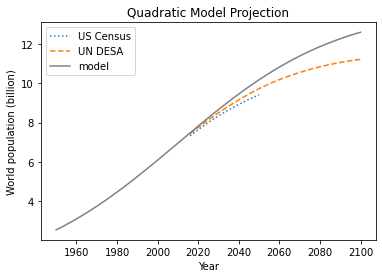

In [37]:
plot_projections(table3)
results.plot(color='gray', label='model',
             title='Quadratic Model Projection',
            legend=True);

The U.N. DESA expects the world population to reach 11 billion around 2100, and then level off.
Projections by U.S. Census are a little lower, and they only go until 2050.  Real demographers expect world population to grow more slowly than our model, probably because their models are broken down by region and country, where conditions are different, and they take into account expected economic development.

<br>

Nevertheless, their projections are qualitatively similar to ours, and
theirs differ from each other almost as much as they differ from ours.
So the results from our model, simple as it is, are not entirely unreasonable.

<br> 

---

## Summary

In this notebook, we:
* generated a projection of future growth using our quadratic model, and compared that model to the projections of professional demographers
* explored the limitations of applying a relatively simple analytical model to a complex real system like world population.

This wraps up the first unit of the textbook, which focuses on the six steps of modeling process.  In the next unit, we'll start to explore the usefulness of differential equations in building more complex models.

<br>

---

### Exercise 1

✅
 In a previous section, we saw a different way to parameterize the quadratic model:

$$ \Delta p = r p (1 - p / K) $$

where $r=\alpha$ and $K=-\alpha/\beta$.  

Write a version of `change_func` that implements this version of the model.  Test it by computing the values of `r` and `K` that correspond to `alpha=0.025` and `beta=-0.0018`, and confirm that you get the same results for the annual growth in the first year of our model.

In [14]:
# Define your parameters and create a system object that includes values for r and K



# Write a new change function called 'change_func_quad_rk'
# that uses r and K to calculate the change in population



In [15]:
# Compare the growth created in 1950-1951 using the new and old form of change_func_quad
test1 = change_func_quad_rk(t_0,p_0,system)

test2 = change_func_quad(t_0,p_0,system)

print(test1,test2)

NameError: ignored

### Exercise 2

✅
  What happens if we start with an initial population above the carrying capacity, like 20 billion?   Run the model from 1950 to 2016, but start with initial populations between 1 and 20 billion, and plot the results for each simulation on the same graph.

A couple hints: 

1) If there are too many labels in the legend, you can plot results like this:

```
    results.plot(label='_nolegend')
```

2) Everytime you use the plot function with a Series (i.e. `results.plot()`), it saves that sequence of data for a plot.  When you use the function a second time with a different sequence (say, with a plot with a different initial population), it does not erase the first sequence, but adds onto it.  So to put multiple lines on the same plot, you just need to run `results.plot` multiple times with a different `results` series.

3) In the final line of the cell, include `plot_estimates()` so that you can see how the census data compares to these models.


In [ ]:
# Define an array of starting populations from 1 to 20 billion using linspace



# Sweep through these starting populations using a 'for' loop and 
# run_simulation; plot each result on the same plot (along with the 
# UN and Census data)



### Exercise 3

✅
What does this plot tell you about quadratically modeled population growth?  Will the lines every cross?  What starting point would lead to the largest stable population?  Does this plot suggest any ways that a quadratic model might be problematic?

<br>

Write a short paragraph exploring these questions.